**Write the names of all group members (max. 5 members)**:
- FirstName1, LastName1
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

### Question 1.a

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


In [78]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
# Use semicolon separator and comma decimal (common for this dataset)
dataframe = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',', encoding='utf-8')
# print(dataframe.head())

# extracrt features X and target y from the dataframe
X_full = dataframe[["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]]
y_full = dataframe[["Exposure", "ClaimNb"]]
y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]

# extract numerical and categorical features
categorical_features = X_full.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_full.drop(columns=categorical_features).columns.tolist()

# print data sizes
print(f'head of X (full dataset) is {X_full.head()} with sieze {X_full.shape}')
print(f'head of y (full dataset) is {y_full.head()} with sieze {y_full.shape}')

numerical_features
categorical_features

head of X (full dataset) is    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region
0         4       9       23         100       B6  Regular     7887    R31
1         4       6       26         100       B6  Regular     2308    R31
2         4       6       26         100       B6  Regular     2308    R31
3         7       4       44          50       B6  Regular       37    R94
4         5       2       29          90       B6  Regular      335    R91 with sieze (678007, 8)
head of y (full dataset) is    Exposure  ClaimNb  ClaimFrequency
0      0.76        0             0.0
1      0.74        0             0.0
2      0.11        0             0.0
3      0.83        0             0.0
4      0.69        0             0.0 with sieze (678007, 3)


C:\Users\drnil\AppData\Local\Temp\ipykernel_30964\54081525.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]


['VehBrand', 'VehGas', 'Region']

In [79]:
# Create dummies for categorical variables (done on full data to ensure consistent columns)
X_encoded = pd.get_dummies(X_full, columns=categorical_features, drop_first=False)
# print(f'X_encoded shape after encoding: {X_encoded.shape}')

# Standardize numeric columns on full data
X_scaler = StandardScaler()
X_encoded[numerical_features] = X_scaler.fit_transform(X_encoded[numerical_features])

# Train-test split
train_idx, test_idx = train_test_split(X_encoded.index, train_size= 0.9, random_state=42)

x_train = X_encoded.loc[train_idx]
x_test = X_encoded.loc[test_idx]
y_train = y_full.loc[train_idx]
y_test = y_full.loc[test_idx]

# Train a Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
p_glm = PoissonRegressor(alpha=0.0)

p_glm.fit(x_train, y_train['ClaimFrequency'], sample_weight=y_train['Exposure'])

y_predict_train = p_glm.predict(x_train)
y_predict_test = p_glm.predict(x_test)

# Ignore non-positive predictions, as they are invalid for
# the Poisson deviance.
mask_test = y_predict_test > 0
if (~mask_test).any():
    n_masked, n_samples = (~mask_test).sum(), mask_test.shape[0]
    print(
        "WARNING: Estimator yields invalid, non-positive predictions "
        f" for {n_masked} samples out of {n_samples}. These predictions "
        "are ignored when computing the Poisson deviance."
    )

mask_train = y_predict_train > 0
if (~mask_train).any():
    n_masked, n_samples = (~mask_train).sum(), mask_train.shape[0]
    print(
        "WARNING: Estimator yields invalid, non-positive predictions "
        f" for {n_masked} samples out of {n_samples}. These predictions "
        "are ignored when computing the Poisson deviance."
    )


# Print GLM performance
print("----- TRAIN PERFORMANCE -----")
print("MSE (train): %.3f" % mean_squared_error(
    y_train["ClaimFrequency"], y_predict_train, sample_weight=y_train["Exposure"]
))
print("MAE (train): %.3f" % mean_absolute_error(
    y_train["ClaimFrequency"], y_predict_train, sample_weight=y_train["Exposure"]
))
print("Poisson Deviance (train): %.3f" % mean_poisson_deviance(
    y_train["ClaimFrequency"], y_predict_train[mask_train], sample_weight=y_train["Exposure"]
))

print("----- TEST PERFORMANCE -----")
print("MSE (test): %.3f" % mean_squared_error(
    y_test["ClaimFrequency"], y_predict_test, sample_weight=y_test["Exposure"]
))
print("MAE (test): %.3f" % mean_absolute_error(
    y_test["ClaimFrequency"], y_predict_test, sample_weight=y_test["Exposure"]
))
print("Poisson Deviance (test): %.3f" % mean_poisson_deviance(
    y_test["ClaimFrequency"], y_predict_test[mask_test], sample_weight=y_test["Exposure"]
))



----- TRAIN PERFORMANCE -----
MSE (train): 0.236
MAE (train): 0.138
Poisson Deviance (train): 0.459
----- TEST PERFORMANCE -----
MSE (test): 0.255
MAE (test): 0.136
Poisson Deviance (test): 0.451


### Question 1.b

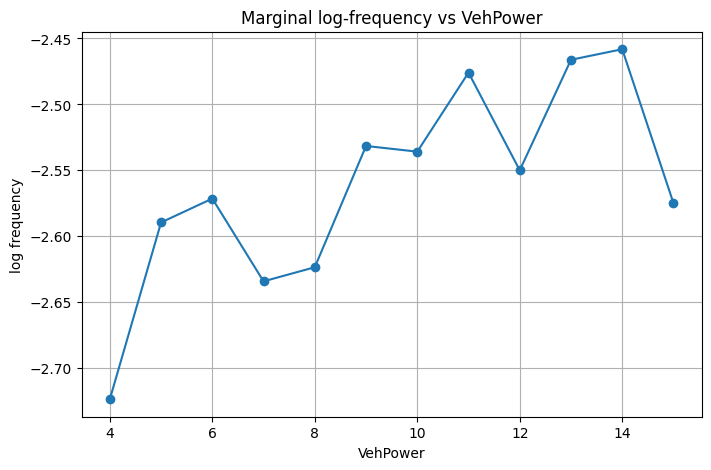

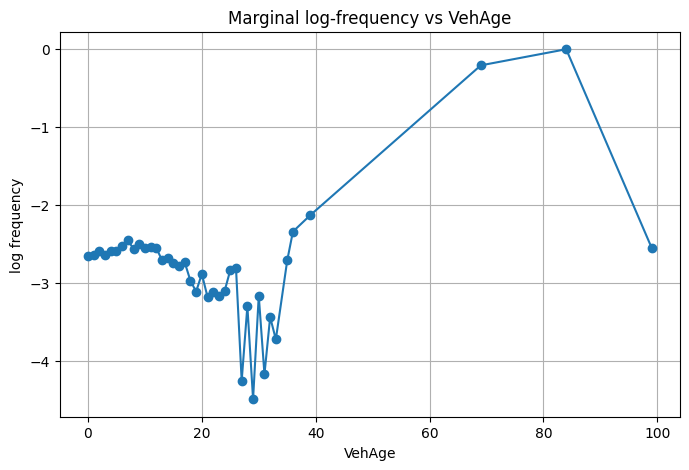

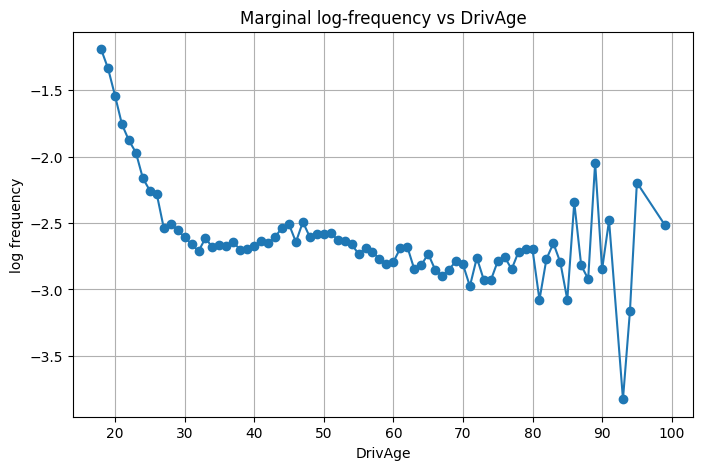

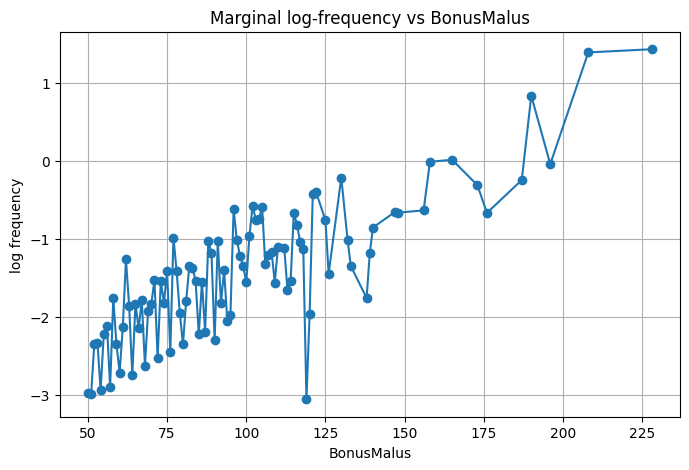

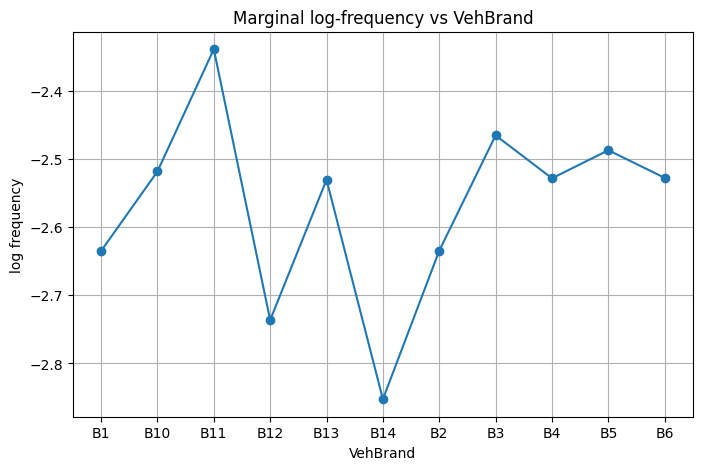

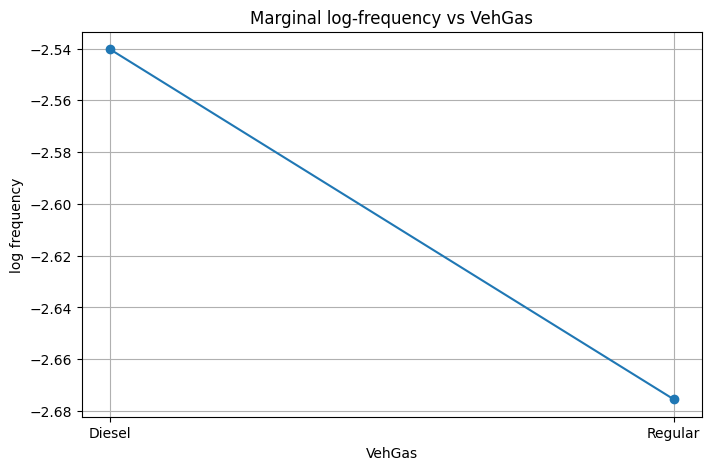

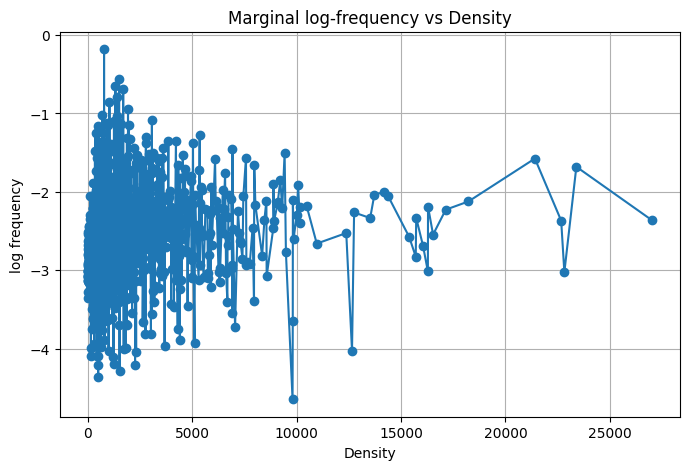

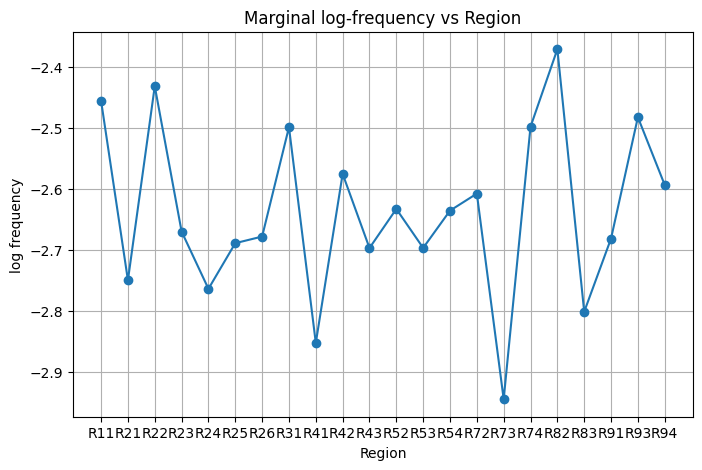

In [72]:
# Plot the empirical marginal log-frequencies
df = pd.concat([X_full, y_full], axis=1)
df = df[df["Exposure"] > 0]
features = X_full.columns

for feature in features:
    grouped = df.groupby(feature).agg({
        "ClaimNb": "sum",
        "Exposure": "sum"
    })

    # empirical frequency
    grouped["freq"] = grouped["ClaimNb"] / grouped["Exposure"]

    # remove zero-frequencies before log
    grouped = grouped[grouped["freq"] > 0]

    # log-frequency
    grouped["log_freq"] = np.log(grouped["freq"])

    # Plot 
    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped["log_freq"], marker='o')
    plt.title(f"Marginal log-frequency vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("log frequency")
    plt.grid(True)
    plt.show()

In [73]:

print("DrivAge skewness:", stats.skew(df["DrivAge"], nan_policy='omit'))
print("VehAge skewness:", stats.skew(df["VehAge"], nan_policy='omit'))
print("Density skewness:", stats.skew(df["Density"], nan_policy='omit'))
print("BonusMalus skewness:", stats.skew(df["BonusMalus"], nan_policy='omit'))


DrivAge skewness: 0.4357688604247925
VehAge skewness: 1.1480121709161462
Density skewness: 4.6513876081038905
BonusMalus skewness: 1.7289171168905313


The primary objective of feature engineering for the Poisson Generalized Linear Model (GLM) is to transform the input features such that the relationship between them and the logarithm of the claim frequency, $\log(\lambda_{i})$, becomes **approximately linear**.

#### 1. Discretization of `VehAge` and `DrivAge` (Actuarial Binning)

We observed that the empirical marginal log-frequencies for `VehAge` (Car Age) and `DrivAge` (Driver Age) exhibited distinct non-linear and non-monotonic trends, which violates the core linearity assumption of the GLM[cite: 3].

* **Rationale for Binning:** Instead of treating these as continuous variables, we transformed them into **categorical factors** via binning. This creates a piecewise constant relationship that can better approximate the true non-linear risk surface[cite: 4].
* **Strategy: Actuarial (Risk-Optimal) Bins:** Our initial strategy using `KBinsDiscretizer(strategy="quantile")` optimized for balanced observation counts per bin but failed to fully separate the risk profiles. We shifted to a **risk-optimal** binning strategy based on actuarial domain knowledge:
    * **`VehAge` Bins:** Defined at boundaries like $(0-5]$, $(5-12]$, and $(12+]$, which correspond to significant risk changes tied to the vehicle's life cycle (e.g., warranty and aging)[cite: 5].
    * **`DrivAge` Bins:** Defined at key risk milestones (e.g., $18-20$, $21-25$, $26-30$, $71+$), capturing periods of high risk (young drivers), rapid risk decrease, and potential late-life increase[cite: 6].
* **Outcome:** By grouping homogeneous risk profiles, the one-hot encoded bins provide the GLM with a much clearer, stepped, and monotonic relationship with the target log-frequency, drastically improving the model's ability to fit the data[cite: 7].

#### 2. Log-Transformation of `Density` and `BonusMalus`

* **Rationale:** Both `Density` and `BonusMalus` are **highly right-skewed** and span several orders of magnitude[cite: 8]. This high skewness makes the linear fit unstable and can be overly influenced by a few high-value outliers.
* **Strategy:** We applied the **$\log(x+1)$ transform** (or $\log1p$). This transformation effectively compresses the heavy right tail, stabilizes the variance, and helps linearize the feature's effect on the target $\log(\lambda)$ as required by the GLM[cite: 9].

### Question 1.c

In [ ]:
# Start with the original X_full containing raw columns
X_fe = X_full.copy()

#  VehAge actuarial bins: (0-5], (5-12], (12-101]

veh_bins = [0, 5, 12, 101]
veh_labels = ["0-5", "6-12", "12+"]

X_fe["VehAgeGLM"] = pd.cut(
    X_fe["VehAge"],
    bins=veh_bins,
    labels=veh_labels,
    include_lowest=True,
    right=True
)

# DrivAge actuarial bins
#   18-20, 21-25, 26-30, 31-40, 41-50, 51-70, 71+

driv_bins = [18, 20, 25, 30, 40, 50, 70, 101]
driv_labels = ["18-20","21-25","26-30","31-40","41-50","51-70","71+"]

X_fe["DrivAgeGLM"] = pd.cut(
    X_fe["DrivAge"],
    bins=driv_bins,
    labels=driv_labels,
    include_lowest=True,
    right=True
)

# Drop the original age variables

X_fe = X_fe.drop(columns=["VehAge", "DrivAge"])

# Log-transform skewed variables

X_fe["Density"] = np.log1p(X_fe["Density"])
X_fe["BonusMalus"] = np.log1p(X_fe["BonusMalus"])

# One-hot encode categorical variables (including new bins)

categorical_features_fe = categorical_features + ["VehAgeGLM", "DrivAgeGLM"]

X_encoded = pd.get_dummies(
    X_fe,
    columns=categorical_features_fe,
    drop_first=False   # <- keep all levels (like R default)
)

# Scale true numerical features (NOT dummies)

numerical_features_fe = ["VehPower", "BonusMalus", "Density"]

scaler = StandardScaler()
X_encoded[numerical_features_fe] = scaler.fit_transform(X_encoded[numerical_features_fe])

# Use existing train_idx and test_idx from your baseline model

x_train = X_encoded.loc[train_idx]
x_test  = X_encoded.loc[test_idx]

y_train = y_full.loc[train_idx]
y_test  = y_full.loc[test_idx]

# Train a Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
p_glm_trans = PoissonRegressor(alpha=0)

p_glm_trans.fit(x_train, y_train['ClaimFrequency'], sample_weight=y_train['Exposure'])

y_pred_train_trans = p_glm_trans.predict(x_train)
y_pred_test_trans = p_glm_trans.predict(x_test)

# Ignore non-positive predictions, as they are invalid for
# the Poisson deviance.
mask_train_trans = y_pred_train_trans > 0
if (~mask_train_trans).any():
    n_masked, n_samples = (~mask_train_trans).sum(), mask_train_trans.shape[0]
    print(
        "WARNING: Estimator yields invalid, non-positive predictions "
        f" for {n_masked} samples out of {n_samples}. These predictions "
        "are ignored when computing the Poisson deviance."
    )

mask_test_trans = y_pred_test_trans > 0
if (~mask_test_trans).any():
    n_masked, n_samples = (~mask_test_trans).sum(), mask_test_trans.shape[0]
    print(
        "WARNING: Estimator yields invalid, non-positive predictions "
        f" for {n_masked} samples out of {n_samples}. These predictions "
        "are ignored when computing the Poisson deviance."
    )

# Print GLM performance
print("----- TRAIN PERFORMANCE -----")
print("MSE (train): %.3f" % mean_squared_error(
    y_train["ClaimFrequency"], y_pred_train_trans, sample_weight=y_train["Exposure"]
))
print("MAE (train): %.3f" % mean_absolute_error(
    y_train["ClaimFrequency"], y_pred_train_trans, sample_weight=y_train["Exposure"]
))
print("Poisson Deviance (train): %.3f" % mean_poisson_deviance(
    y_train["ClaimFrequency"], y_pred_train_trans[mask_train_trans], sample_weight=y_train["Exposure"]
))

print("----- TEST PERFORMANCE -----")
print("MSE (test): %.3f" % mean_squared_error(
    y_test["ClaimFrequency"], y_pred_test_trans, sample_weight=y_test["Exposure"]
))
print("MAE (test): %.3f" % mean_absolute_error(
    y_test["ClaimFrequency"], y_pred_test_trans, sample_weight=y_test["Exposure"]
))
print("Poisson Deviance (test): %.3f" % mean_poisson_deviance(
    y_test["ClaimFrequency"], y_pred_test_trans[mask_test_trans], sample_weight=y_test["Exposure"]
))

poiss_train_base = mean_poisson_deviance(
    y_train["ClaimFrequency"], y_predict_train[mask_train], sample_weight=y_train["Exposure"]
)
poiss_test_base = mean_poisson_deviance(
    y_test["ClaimFrequency"], y_predict_test[mask_test], sample_weight=y_test["Exposure"]
)

poiss_train_trans = mean_poisson_deviance(
    y_train["ClaimFrequency"], y_pred_train_trans[mask_train_trans], sample_weight=y_train["Exposure"]
)
poiss_test_trans = mean_poisson_deviance(
    y_test["ClaimFrequency"], y_pred_test_trans[mask_test_trans], sample_weight=y_test["Exposure"]
)

# ABSOLUTE improvements (baseline - transformed)
impr_train_abs = poiss_train_base - poiss_train_trans
impr_test_abs  = poiss_test_base - poiss_test_trans

# RELATIVE improvements (percentage reduction in loss)
impr_train_pct = impr_train_abs / poiss_train_base * 100
impr_test_pct  = impr_test_abs / poiss_test_base * 100

print("\n----- IMPROVEMENT OF TRANSFORMED MODEL OVER BASELINE (Poisson Deviance) -----")
print("Train: Δ = %.3f  (%.2f%% reduction)" % (impr_train_abs, impr_train_pct))
print("Test:  Δ = %.3f  (%.2f%% reduction)" % (impr_test_abs, impr_test_pct))


----- TRAIN PERFORMANCE -----
MSE (train): 0.235
MAE (train): 0.138
Poisson Deviance (train): 0.457
----- TEST PERFORMANCE -----
MSE (test): 0.255
MAE (test): 0.136
Poisson Deviance (test): 0.447

----- IMPROVEMENT OF TRANSFORMED MODEL OVER BASELINE (Poisson Deviance) -----
Train: Δ = 0.003  (0.55% reduction)
Test:  Δ = 0.003  (0.76% reduction)


# Exercise 2 (Poisson FNN)

### Question 2.a

In [ ]:
# Neural network implementation

### Question 2.b

In [ ]:
# Train Poisson feedforward neural network model

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the Poisson GLM model of Question 1.b.

# Exercise 3 (Tree-based methods)

### Question 3.a

In [ ]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [ ]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [ ]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets